In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
n_s = 1000
n_d = 100
n_train = 10
n_params = 1
n_summaries = 2
input_shape = (10,)
t_fid = np.array([1.])
dt = np.array([0.1])
ns = tf.constant(n_s, dtype=tf.float32)
nd = tf.constant(n_d, dtype=tf.float32)
θ_fid = tf.constant(t_fid, dtype=tf.float32)
dθ = tf.constant(dt, dtype=tf.float32)

In [3]:
seed = 0
np.random.seed(seed)
simulations = np.random.normal(0., np.sqrt(t_fid[0]), (n_train * max(n_s, n_d),) + input_shape)[:n_train * n_s].astype(np.float32)
np.random.seed(seed)
simulations_m = np.random.normal(0., np.sqrt(t_fid[0] - dt[0]), (n_train * max(n_s, n_d), n_params) + input_shape)[:n_train * n_d].astype(np.float32)
np.random.seed(seed)
simulations_p = np.random.normal(0., np.sqrt(t_fid[0] + dt[0]), (n_train * max(n_s, n_d), n_params) + input_shape)[:n_train * n_d].astype(np.float32)
seed = 1
np.random.seed(seed)
test_simulations = np.random.normal(0., np.sqrt(t_fid[0]), (max(n_s, n_d),) + input_shape)[:n_s].astype(np.float32)
np.random.seed(seed)
test_simulations_m = np.random.normal(0., np.sqrt(t_fid[0] - dt[0]), (max(n_s, n_d), n_params) + input_shape)[:n_d].astype(np.float32)
np.random.seed(seed)
test_simulations_p = np.random.normal(0., np.sqrt(t_fid[0] + dt[0]), (max(n_s, n_d), n_params) + input_shape)[:n_d].astype(np.float32)

In [4]:
sims_at_once = 17
batches = np.ceil(n_s / sims_at_once).astype(int)

train_sims = tf.data.Dataset.from_tensor_slices(simulations)
train_sims = train_sims.batch(n_s).shuffle(n_s * n_train, reshuffle_each_iteration=False)
train_sims = train_sims.map(lambda x: tf.data.Dataset.from_tensor_slices(x).repeat(2))
#train_sims = train_sims.map(lambda x: tf.data.Dataset.from_tensor_slices(x).batch(sims_at_once))



#sims_inds = tf.data.Dataset.from_tensor_slices(np.arange(n_s)[:, np.newaxis].astype(np.int32))
#sims_inds = sims_inds.batch(sims_at_once)

#ders_at_once = n_d

#train_ders = tf.data.Dataset.from_tensor_slices((simulations_m, simulations_p))
#train_ders = train_ders.batch(ders_at_once).shuffle(10 * n_d)
#der_inds = tf.data.Dataset.from_tensor_slices(np.arange(n_d)[:, np.newaxis].astype(np.int32))
#der_inds = der_inds.batch(ders_at_once)

In [8]:
iterator = iter(train_sims)

In [5]:
sims_iterator = iter(train_sims)

In [12]:
batch_iterator = iter(next(sims_iterator))

In [15]:
print(next(batch_iterator).shape)

(17, 10)


In [35]:
def staggered_train(train_sims, sims_inds, train_ders, der_inds, λ, α):
    x, x_m, x_p = get_summaries(train_sims, sims_inds, train_ders, der_inds)
    C, μ_offset = get_covariance(x)
    Cinv = tf.linalg.inv(C)
    dμdθ = get_derivative_mean(x_m, x_p)
    F = get_Fisher(Cinv, dμdθ)
    
    dCdx = get_covariance_derivative(μ_offset)
    dΛdx, dΛdx_m, dΛdx_p = get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx)
    dΛ_2dx, r = get_regularisation_derivative(C, Cinv, dCdx, λ, α)
    dΛdx = tf.add(dΛ_2dx, dΛdx)
    
    for i in sims_inds:
        print(i)
    return F

In [79]:
for i in train_sims:
    counter = 0
    a = []
    b = []
    for j in i:
        a.append(j)
        counter += 1
        if counter >= batches:
            break
    for j in i:
        b.append(j)

In [5]:
test_sims = tf.data.Dataset.from_tensor_slices(test_simulations)
test_sims = test_sims.batch(sims_at_once)
test_ders = tf.data.Dataset.from_tensor_slices((test_simulations_m, test_simulations_p))
test_ders = test_ders.batch(ders_at_once)

In [6]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=(10,)),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(n_summaries),
     tf.keras.layers.Activation("tanh")
    ])
opt = tf.keras.optimizers.Adam()

In [7]:
@tf.function
def get_summaries(train_sims, sims_inds, train_ders, der_inds):
    x = tf.zeros(shape=(n_s, n_summaries))
    for i in sims_inds:
        s = next(iter(train_sims))
        x = tf.tensor_scatter_nd_update(x, i, model(s[: tf.shape(i)[0]]))
    x_m = tf.zeros(shape=(n_d, n_params, n_summaries))
    x_p = tf.zeros(shape=(n_d, n_params, n_summaries))
    for i in der_inds:
        s_m, s_p = next(iter(train_ders))
        x_m = tf.tensor_scatter_nd_update(x_m, i, model(s_m[: tf.shape(i)[0]]))
        x_p = tf.tensor_scatter_nd_update(x_p, i, model(s_p[: tf.shape(i)[0]]))
    return x, x_m, x_p

In [8]:
def get_covariance(x):
    μ = tf.reduce_mean(x, 
                       axis=0, 
                       keepdims=True)
    μ_offset = tf.subtract(x, μ)
    
    C = tf.divide(
        tf.einsum(
            "ij,ik->jk", 
            μ_offset, 
            μ_offset), 
        tf.subtract(ns, 1.))
    return C, μ_offset

In [9]:
def get_derivative_mean(x_m, x_p):
    return tf.reduce_mean(
        tf.einsum(
            "ijk,j->ijk",
            tf.subtract(x_p, x_m),
            tf.divide(
                1.,
                tf.multiply(2., dθ))),
            axis=0)

In [10]:
def get_Fisher(Cinv, dμdθ):
    F = tf.linalg.band_part(
            tf.einsum(
                "ij,kj->ik", 
                dμdθ, 
                tf.einsum(
                    "ij,kj->ki", 
                    Cinv, 
                    dμdθ)), 0, -1)
    return tf.multiply(
        0.5, 
        tf.add(
            F, 
            tf.transpose(F, perm=[1, 0])))

In [11]:
def get_covariance_derivative(μ_offset):
    dxdx = tf.einsum(
        "ij,kl->ijkl", 
        tf.eye(n_s, n_s), 
        tf.eye(n_summaries, n_summaries))
    dμ_offsetdx = tf.subtract(
        dxdx, 
        tf.reduce_mean(
            dxdx, 
            axis=0, 
            keepdims=True))
    return tf.divide(
        tf.reduce_sum(
            tf.add(
                tf.einsum(
                    "ijkl,im->ijkml", 
                    dμ_offsetdx, 
                    μ_offset),
                tf.einsum(
                    "ij,iklm->ikjlm",
                    μ_offset, 
                    dμ_offsetdx)),
            axis=0),
        tf.subtract(ns, 1.))

In [12]:
def get_derivative_mean_derivative():
    dxdx = tf.einsum(
        "ij,kl,mn->ijklmn", 
        tf.eye(n_d, n_d),
        tf.eye(n_params, n_params),
        tf.eye(n_summaries, n_summaries))
    ddμdθdx = tf.reduce_mean(
        tf.einsum(
            "ijklmn,l->ijkmnl",
            dxdx, 
            tf.divide(
                1., 
                tf.multiply(2., dθ))), 
        axis=0)
    return ddμdθdx

In [13]:
def get_fisher_derivative(Cinv, dμdθ, dCdx):
    ddμdθdx = get_derivative_mean_derivative()
    Cinvdμdθ = tf.einsum(
        "ij,kj->ki", 
        Cinv, 
        dμdθ)
    dFdx = tf.linalg.band_part(
        tf.einsum(
            "ij,kljm->kmil",
            dμdθ, 
            tf.einsum(
                "ij,kljm->klim",
                Cinv, 
                tf.einsum(
                    "ijkl,mk->imjl",
                    dCdx, 
                    Cinvdμdθ))), 0, -1)
    dFdx = tf.multiply(
        -0.5,
        tf.add(
            dFdx, 
            tf.transpose(
                dFdx, 
                perm=[0, 1, 3, 2])))
    
    dFdx_m_a = tf.linalg.band_part(
            tf.einsum(
                "ijklm,nk->imljn",
                -ddμdθdx, 
                Cinvdμdθ), 0, -1)
    dFdx_m_b = tf.linalg.band_part(
            tf.einsum(
                "ij,kljmn->knmil",
                dμdθ, 
                tf.einsum(
                    "ij,kljmn->klimn",
                    Cinv, 
                    -ddμdθdx)), 0, -1)  
    dFdx_m = tf.multiply(
        0.5,
        tf.add(
            tf.add(
                dFdx_m_a,
                tf.transpose(
                    dFdx_m_a,
                    perm=[0, 1, 2, 4, 3])),
            tf.add(
                dFdx_m_b,
                tf.transpose(
                    dFdx_m_b,
                    perm=[0, 1, 2, 4, 3]))))
    
    dFdx_p_a = tf.linalg.band_part(
            tf.einsum(
                "ijklm,nk->imljn",
                ddμdθdx, 
                Cinvdμdθ), 0, -1)
    dFdx_p_b = tf.linalg.band_part(
            tf.einsum(
                "ij,kljmn->knmil",
                dμdθ, 
                tf.einsum(
                    "ij,kljmn->klimn",
                    Cinv, 
                    ddμdθdx)), 0, -1)  
    dFdx_p = tf.multiply(
        0.5,
        tf.add(
            tf.add(
                dFdx_p_a,
                tf.transpose(
                    dFdx_p_a,
                    perm=[0, 1, 2, 4, 3])),
            tf.add(
                dFdx_p_b,
                tf.transpose(
                    dFdx_p_b,
                    perm=[0, 1, 2, 4, 3]))))
    return dFdx, dFdx_m, dFdx_p

In [19]:
def get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx):
    Finv = tf.linalg.inv(F)
    dFdx, dFdx_m, dFdx_p = get_fisher_derivative(Cinv, dμdθ, dCdx)
    
    dΛdx = -tf.linalg.trace(
        tf.einsum(
            "ij,kljm->klim",
            Finv, 
            dFdx))
    dΛdx_m = -tf.linalg.trace(
        tf.einsum(
            "ij,klmjn->klmin",
            Finv, 
            dFdx_m))
    dΛdx_p = -tf.linalg.trace(
        tf.einsum(
            "ij,klmjn->klmin", 
            Finv, 
            dFdx_p))
    return dΛdx, dΛdx_m, dΛdx_p

In [28]:
def get_regularisation(C, Cinv):
    I = tf.eye(n_summaries)
    CmI = tf.subtract(C, I)
    CinvmI = tf.subtract(Cinv, I)
    Λ_2 = tf.multiply(0.5,
        tf.add(
            tf.square(
                tf.norm(CmI, 
                        ord="fro", 
                        axis=(0, 1))),
            tf.square(
                tf.norm(CinvmI, 
                        ord="fro", 
                        axis=(0, 1)))))
    return Λ_2, CmI

In [29]:
def get_regularisation_strength(Λ_2, λ, α):
    rate = tf.multiply(-α, Λ_2)
    e_rate = tf.exp(rate)
    r = tf.divide(
            tf.multiply(
                λ, 
                Λ_2), 
            tf.add(
                Λ_2, 
                e_rate))
    drdΛ_2 = tf.multiply(
        r, 
        tf.add(
            1., 
            tf.divide(
                tf.multiply(
                    tf.add(
                        1.,
                        tf.multiply(
                            α,
                            Λ_2)),
                    e_rate),
                tf.add(
                    Λ_2,
                    e_rate))))
    return r, drdΛ_2

In [30]:
def get_regularisation_derivative(C, Cinv, dCdx, λ, α):
    Λ_2, CmI = get_regularisation(C, Cinv)
    r, drdΛ_2= get_regularisation_strength(Λ_2, λ, α)
    Cinv2 = tf.einsum(
        "ij,jk->ik", 
        Cinv, 
        Cinv)
    Cinv3 = tf.einsum(
        "ij,jk->ik",
        Cinv2,
        Cinv)
    dΛ_2dx = tf.multiply(
        tf.add(
            tf.multiply(
                Λ_2,
                drdΛ_2),
            r),            
        tf.linalg.trace(
            tf.einsum(
                "ij,kjlm->kilm",
                tf.add(
                    CmI, 
                    tf.subtract(
                        Cinv2, 
                        Cinv3)),
                dCdx)))
    return dΛ_2dx, r

In [36]:
staggered_train(train_sims, sims_inds, train_ders, der_inds, 10., 10.)

tf.Tensor(
[[  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [136]
 [137]
 [138]
 [139]
 [140]
 [

<tf.Tensor: id=2593, shape=(1, 1), dtype=float32, numpy=array([[0.00475057]], dtype=float32)>

In [34]:
def get_gradients(s):
    with tf.GradientTape(persistent=True) as t:
        x = model(s)
    return x, t.jacobian(x, model.variables, experimental_use_pfor=True)

In [17]:
def apply_gradients(F, C, Cinv, dμdθ, μ_offset, dxdw, dx_mdw, dx_pdw, λ, α):
    dCdx = get_covariance_derivative(μ_offset)    
    dΛdx, dΛdx_m, dΛdx_p = get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx)
    
    dΛ_2dx, r = get_regularisation_derivative(C, Cinv, dCdx, λ, α)
    dΛdx = tf.add(dΛ_2dx, dΛdx)
    
    gradients = []
    for layer in range(len(model.variables)):
        gradients.append(
            tf.add(
                tf.divide(
                    tf.einsum(
                        "ij,ij...->...", 
                        dΛdx, 
                        dxdw[layer]),
                    ns),
                tf.divide(
                    tf.add(
                        tf.einsum(
                            "ijk,ijk...->...", 
                            dΛdx_m,
                            dx_mdw[layer]),
                        tf.einsum(
                            "ijk,ijk...->...", 
                            dΛdx_p, 
                            dx_pdw[layer])),
                    nd)))
    opt.apply_gradients(zip(gradients, model.variables))
    return r

In [18]:
@tf.function
def training_iteration(s, s_m, s_p, α, λ):
    x, dxdw = get_gradients(s)
    x_m, dx_mdw = get_gradients(s_m)
    x_p, dx_pdw = get_gradients(s_p)
    
    C, μ_offset = get_covariance(x)
    Cinv = tf.linalg.inv(C)
    dμdθ = get_derivative_mean(x_m, x_p)
    
    F = get_fisher(Cinv, dμdθ)
        
    r = apply_gradients(F, C, Cinv, dμdθ, μ_offset, dxdw, dx_mdw, dx_pdw, λ, α)
    
    return tf.linalg.det(F), tf.linalg.det(C), tf.linalg.det(Cinv), dμdθ, r

In [19]:
@tf.function
def evaluate(s, s_m, s_p):
    x = model(s)
    x_m = model(s_m)
    x_p = model(s_p)
    C, _ = get_covariance(x)
    Cinv = tf.linalg.inv(C)
    dμdθ = get_derivative_mean(x_m, x_p)
    F = get_fisher(Cinv, dμdθ)
    return tf.linalg.det(F), tf.linalg.det(C), tf.linalg.det(Cinv), dμdθ

In [20]:
def get_constraint_rate(ϵ, λ):
    return np.float32(-np.log((λ - 1.) * ϵ + ϵ**2. / (1. + ϵ)) / ϵ)

In [21]:
λ = np.float32(10.)
α = get_constraint_rate(1e-2, λ)

In [22]:
F_arr = []
C_arr = []
Cinv_arr = []
dμdθ_arr = []
r_arr = []

test_F_arr = []
test_C_arr = []
test_Cinv_arr = []
test_dμdθ_arr = []

In [ ]:
bar = tqdm.tnrange(10000, desc="iterations")
for i in bar:
    sim = next(iter(train_sims))
    der_m, der_p = next(iter(train_ders))
    F_temp, C_temp, Cinv_temp, dμdθ_temp, r_temp = training_iteration(sim, der_m, der_p, α, λ)
    F_arr.append(F_temp.numpy())
    C_arr.append(C_temp.numpy())
    Cinv_arr.append(Cinv_temp.numpy())
    dμdθ_arr.append(dμdθ_temp.numpy())
    r_arr.append(r_temp.numpy())
    sim = next(iter(test_sims))
    der_m, der_p = next(iter(test_ders))
    F_temp, C_temp, Cinv_temp, dμdθ_temp = evaluate(sim, der_m, der_p)
    test_F_arr.append(F_temp.numpy())
    test_C_arr.append(C_temp.numpy())
    test_Cinv_arr.append(Cinv_temp.numpy())
    test_dμdθ_arr.append(dμdθ_temp.numpy())
    
    bar.set_postfix(
        F=[F_arr[-1], test_F_arr[-1]], 
        C=[C_arr[-1], test_C_arr[-1]], 
        Cinv=[Cinv_arr[-1], test_Cinv_arr[-1]], 
        dμdθ=[dμdθ_arr[-1], test_dμdθ_arr[-1]], 
        r=r_arr[-1])

In [ ]:
plt.plot(F_arr, color="C0", label="$|{\\bf F}|$")
plt.plot(test_F_arr, color="C1", label="$|{\\bf F}|_{\\rm test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$|{\\bf F}|$")
plt.legend(frameon=False)

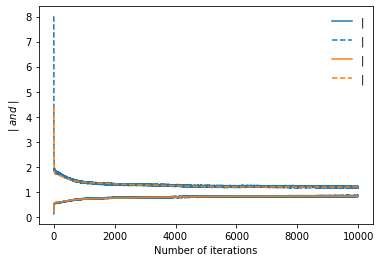

In [25]:
plt.plot(C_arr, color="C0", label="$|{\\bf C}|$")
plt.plot(Cinv_arr, color="C0", linestyle="dashed", label="$|{\\bf C}^{-1}|$")
plt.plot(test_C_arr, color="C1", label="$|{\\bf C}|_{\\rm test}$")
plt.plot(test_Cinv_arr, color="C1", linestyle="dashed", label="$|{\\bf C}^{-1}|_{\\rm test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$|{\\bf C}|$ and $|{\\bf C}^{-1}|$")
plt.legend(frameon=False)

In [26]:
plt.plot(np.array(dμdθ_arr)[:, 0, :], color="C0", label="$\frac{\partial\mu}{\partial\theta}$")
plt.plot(np.array(test_dμdθ_arr)[:, 0, :], color="C1", label="$\left(\frac{\partial\mu}{\partial\theta}\right)_\textsf{test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$\frac{\partial\mu}{\partial\theta}$")
plt.legend(frameon=False)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.plot(r_arr)
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("$r(\Lambda_2)$")

In [9]:
@tf.function
def simple_iteration(s, s_m, s_p, λ, α):
    with tf.GradientTape(persistent=True) as taμ
        x = model(s)
        x_m = model(s_m)
        x_p = model(s_p)
    dxdw = tape.jacobian(x, model.variables)
    dx_mdw = tape.jacobian(x_m, model.variables)
    dx_pdw = tape.jacobian(x_p, model.variables)
    del tape
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(x_m)
        tape.watch(x_p)
        C = tfp.stats.covariance(x)
        Cinv = tf.linalg.inv(C)
        dμdθ = tf.reduce_mean(tf.divide(tf.subtract(x_p, x_m), tf.expand_dims(tf.expand_dims(dθ, 0), 2)), axis=0)
        F_half = tf.linalg.band_part(tf.linalg.matmul(dμdθ, tf.linalg.matmul(Cinv, dμdθ, transpose_b=True)), 0, -1)
        F = tf.multiply(0.5, tf.add(F_half, tf.linalg.matrix_transpose(F_half)))
        logdetF = tf.linalg.slogdet(F)
        I = tf.eye(n_summaries, n_summaries)
        Λ_2 = tf.add(tf.reduce_sum(tf.square(tf.subtract(C, I))), tf.reduce_sum(tf.square(tf.subtract(Cinv, I))))
        r = tf.divide(tf.multiply(λ, Λ_2), tf.add(Λ_2, tf.exp(tf.multiply(-α, Λ_2))))
        Λ = tf.subtract(tf.multiply(r, Λ_2), tf.multiply(logdetF[0], logdetF[1]))
    dΛdx = tape.jacobian(Λ, x)
    dΛdx_m = tape.jacobian(Λ, x_m)
    dΛdx_p = tape.jacobian(Λ, x_p)
    del tape
    gradient = []
    for layer in range(len(model.variables)):
        gradient.append(
            tf.add(
                tf.divide(tf.einsum("ij...,ij->...", dxdw[layer], dΛdx), ns),
                tf.divide(
                    tf.add(
                        tf.einsum("ijk...,ijk->...", dx_mdw[layer], dΛdx_m),
                        tf.einsum("ijk...,ijk->...", dx_mdw[layer], dΛdx_m)), nd)))
    
    opt.apply_gradients(zip(gradient, model.variables))
    return tf.linalg.det(F), tf.linalg.det(C), tf.linalg.det(Cinv), dμdθ, r

In [10]:
λ = 10.
ϵ = 1e-2
α = np.float32(-np.log((λ - 1.) * ϵ + ϵ**2. / (1. + ϵ)) / ϵ)
F_arr = []
C_arr = []
Cinv_arr = []
dμdθ_arr = []
r_arr = []
print(α)

0.9531018


In [16]:
bar = tqdm.tnrange(2500, desc="iterations")
for i in bar:
    sim = next(iter(train_sims))
    der_m, der_p = next(iter(train_ders))
    F_temp, C_temp, Cinv_temp, dμdθ_temp, r_temp = simple_iteration(sim, der_m, der_p, λ, α)
    F_arr.append(F_temp)
    C_arr.append(C_temp)
    Cinv_arr.append(Cinv_temp)
    dμdθ_arr.append(dμdθ_temp)
    r_arr.append(r_temp)
    bar.set_postfix(F=F_arr[-1], C=C_arr[-1], Cinv=Cinv_arr[-1], dμdθ=dμdθ_arr[-1], r=r_arr[-1])